In [ ]:
!git clone https://github.com/RobertoLig/cond-data-flow.git

Cloning into 'cond-data-flow'...
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
#For saving plots automatically
from google.colab import files

#To load external functions
from google.colab import drive
drive.mount('/content/drive')

!git clone git@github.com:RobertoLig/cond-data-flow.git

%cd cond-data-flow



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning into 'cond-data-flow'...
Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
[Errno 2] No such file or directory: 'cond-data-flow'
/content


In [ ]:
%run '/content/drive/My Drive/Flow Functions/kernels.py'
%run '/content/drive/My Drive/Flow Functions/sample_points.py'
%run '/content/drive/My Drive/Flow Functions/generate_params.py'
%run '/content/drive/My Drive/Flow Functions/plot_tools.py'

In [ ]:
# define dataset
N = 500
M = 20 * N
LM = True

data_array = sample_moon(N, M, LM)
Zinitial = data_array[0]
Zcurrent = data_array[1]
Zjoint = data_array[2]
Zlm = data_array[3]

In [ ]:

"""
Parameters for gradient flow
Currently picking bounds for learning rates and bandwidths is extremely finnicky (easy to get NaNs)
Planning to introduce gradient clipping to avoid this
"""

#Choose kernel and bandwidth selector
RHS = RHS_poly
d = dists

maxIter = 10_000 # number of flow iterations
max_lr = .1
min_lr = .1
lrs = make_lrs(Zcurrent, Zjoint, min_lr, max_lr) # nearest-neighbor based local learning rate

#If SGD true, then only use Msub, Nsub points
SGD = False
Msub = int(M/5); Nsub = int(N/4)



#For bandwidth selections: # of neighbor points, bandwidth range
neighbors_product = 25
neighbors_joint = 15
min_bw = .1
max_bw = .2

#Determines how many iterations between bandwidth refreshes
refresh_rate = 100

#Create triangular cost
lam = 100_000
lamMat = make_lambda(lam, 1, 1)

#Minimum and maximum values for gradient clipping
grad_min = -lam
grad_max = lam

if SGD:
  Zcr = Zcurrent[np.random.choice(M, size = Msub, replace = False, p = None),:]
  Zjnt = Zjoint[np.random.choice(N, size = Nsub, replace = False, p = None),:]

  bw = d(Zcr, neighbors_product, min_bw, max_bw)
  bwtar = d(Zjoint, neighbors_joint, min_bw, max_bw)
else:
  bw = d(Zcurrent, neighbors_product, min_bw, max_bw)
  bwtar = d(Zjoint, neighbors_joint, min_bw, max_bw)


In [ ]:
"""
Main Loop Basis
JIT Breaks this for some reason
"""

def single_iter(Zcr, bw, lrs):

  G = RHS(Zcr, Zcurrent, Zjoint, bw, bwtar)
  G_tri = jnp.matmul(lamMat, G).T
  G_clip = jnp.clip(G_tri, grad_min, grad_max)

  return Zcr - lrs * G_clip

single_iters = vmap(single_iter, in_axes = (0, 0, None))

In [ ]:
"""
Simple Main Loop
"""

now = time.time()

for i in range(maxIter):

  if (i % refresh_rate) == 0:
    bw = d(Zcurrent, neighbors_product, min_bw, max_bw)
    lrs = make_lrs(Zcurrent, Zjoint, min_lr, max_lr)

  Zcurrent = single_iter(Zcurrent, bw, lrs)

t = jnp.round(time.time() - now, 2)
print('Execution time =', t)

Execution time = 73.47


In [ ]:
"""
Main Loop with integrated LMs
"""

now = time.time()

for i in range(maxIter):

  if (i % refresh_rate) == 0:
    bw = d(Zcurrent, neighbors_product, min_bw, max_bw)
    bw_lm = d(Zlm, neighbors_product, min_bw, max_bw)
    lrs = make_lrs(Zcurrent, Zjoint, min_lr, max_lr)

  """
  flows = jnp.array([Zcurrent, Zlm])
  bws = jnp.array([bw, bw_lm])

  updates = single_iters(flows, bws, lrs)
  Zcurrent = updates[0]
  Zlm = updates[1]
  """

  Zlm = single_iter(Zlm, bw_lm, lrs)
  Zcurrent = single_iter(Zcurrent, bw, lrs)

t = jnp.round(time.time() - now, 2)
print('Execution time =', t)

Execution time = 147.95999


Mean movement in the y direction 196.67409


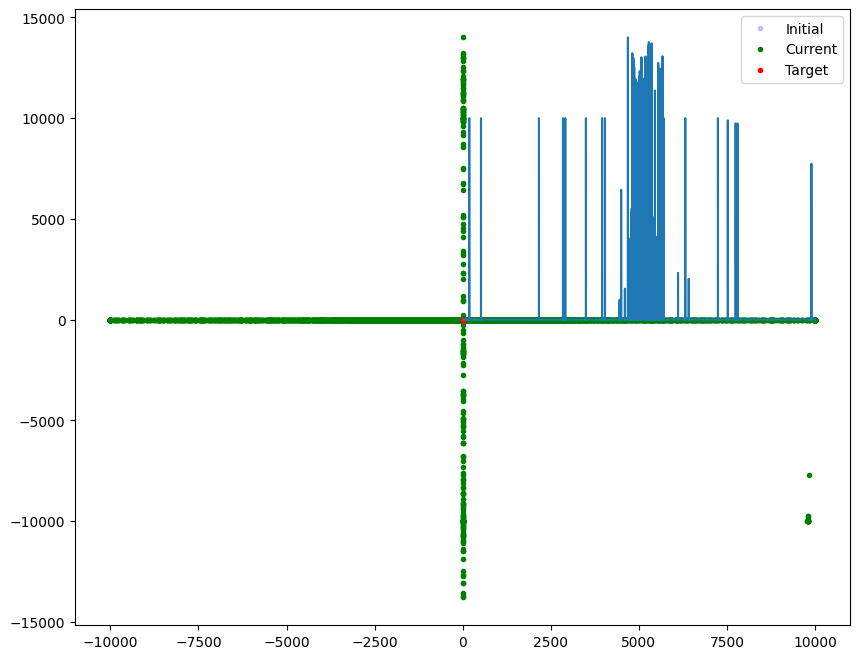

In [ ]:
#For plot saving
info = [RHS.__name__, str(maxIter), str(min_bw) + " to " + str(max_bw), str(min_lr) + " to " + str(max_lr), str(neighbors_product), str(refresh_rate), "ss"]
save = False
make_plot(info, save, Zinitial, Zcurrent, Zjoint)


Mean movement in the y direction 196.67409


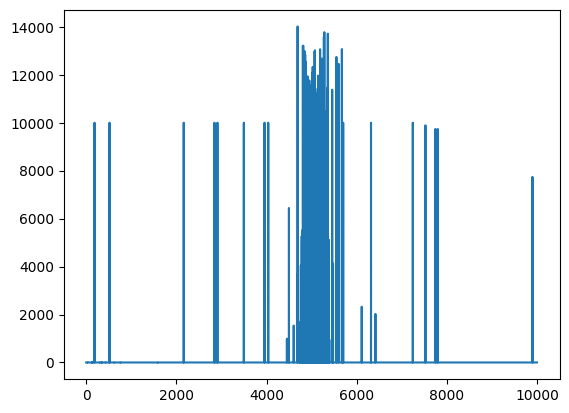

In [ ]:
y_mvmt(Zcurrent, Zinitial)

In [ ]:
#Estimate with Lagrangia markers
#Check the estimated conditional density rho(x|ystr)
ystr=1
LM_est(ystr)

NameError: ignored